In [16]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,vcat([2],4:(end-1))]
dat1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,3]
dat2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,end]
dat[:,2:end] .= log.(dat[:,2:end] .+ 1e-2)
dat[1:4,:]

Row,year,lat_36_00450,lat_36_00900,lat_36_01350,lat_36_01800,lat_36_02250,lat_36_02700,lat_36_03150,lat_36_03600,lat_36_04050,lat_36_04500,lat_36_05849,lat_36_06299,lat_36_06749,lat_36_07199,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449,lat_36_09899,lat_36_10349,lat_36_10799,lat_36_11249,lat_36_11698,lat_36_12148,lat_36_12598,lat_36_13048,lat_36_13498,lat_36_13948,lat_36_14398,lat_36_14848,lat_36_15298,lat_36_15748,lat_36_16198,lat_36_16648,lat_36_17098,lat_36_17547,lat_36_17997,lat_36_18447,lat_36_19347,lat_36_19797,lat_36_20247,lat_36_20697,lat_36_21147,lat_36_21597
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,-2.43795,-1.9025,-3.84914,-2.52832,-2.81083,-4.36208,-3.05077,-2.64698,-2.078,-4.60517,-4.60517,-4.4405,-0.915513,-1.75641,-1.20027,-1.94119,-1.03678,-3.6812,-4.60517,-2.11977,-0.804252,-1.58474,-1.26537,-4.60517,-1.63233,-1.64554,-3.99349,-1.54454,-1.5023,-2.58547,-1.63941,-1.50151,-3.37547,-1.77406,-1.05368,-1.8842,-1.73123,-2.8656,-3.78178,-4.60517,-3.34028,-0.681664,-0.955537,-1.71432,-1.09559
2,1985,-0.800995,-0.0137745,-0.83556,-0.240423,-0.495683,-1.25267,-0.535848,-0.327685,-0.13533,-1.00457,-4.60517,-1.18451,-0.0618075,-0.0644594,-0.204018,-0.0798734,0.00995033,-0.143568,-2.46943,-0.270178,0.00995033,0.00995033,0.00995033,-0.360923,0.00995033,0.00995033,-0.972054,0.00995033,-0.0189833,0.00995033,0.00995033,-0.100928,-0.803451,-0.223033,-0.459067,-0.522358,-0.316985,-0.445064,-1.22421,-3.97851,0.00995033,0.00995033,0.00995033,0.00995033,0.00995033
3,1986,-1.80098,-0.83091,-1.09486,-0.365123,-1.0107,-1.4645,-0.744626,-1.55959,-1.72477,-3.80866,-4.60517,-3.27246,-1.5777,-1.87296,-1.83918,-1.09126,-1.98384,-1.46933,-4.07004,-1.38429,-1.06248,-0.923027,-0.944995,-4.2058,-1.92127,-1.7083,-2.88632,-1.65098,-1.98705,-1.68482,-0.840014,-1.78871,-3.57587,-2.22096,-1.06171,-2.03188,-1.18065,-1.0208,-0.732183,-1.65437,-1.36028,-1.4828,-2.29586,-1.45745,-2.77032
4,1987,-0.817995,-0.640768,-1.0418,-0.291619,-0.977762,-1.07758,-0.639388,-1.05079,-1.25423,-2.63243,-4.60517,-2.13682,-0.625342,-0.879395,-0.796447,-0.757462,-0.825752,-2.17458,-3.33211,-1.30186,-0.760597,-0.94546,-1.07241,-1.57449,-1.05118,-1.04158,-2.51289,-1.23411,-1.34993,-1.25475,-0.864295,-0.919857,-4.20464,-1.1366,-0.550202,-0.548903,-0.84814,-0.67096,-0.173496,-0.579667,-0.618157,-0.589606,-0.49708,-0.816267,-1.35927


In [17]:
dat_K = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,4:(end-1)]
K1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,3]
K2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,end]
K = Matrix(dat_K)[1,:]
K

45-element Vector{Float64}:
 0.174105861214001
 0.687939289908754
 1.0
 0.358026922034511
 0.361700846207125
 0.270952911534717
 0.337509159715321
 0.120534826994308
 0.114090402625952
 0.00942170827435982
 ⋮
 0.0294435912106885
 0.0336093795484888
 0.0274118910671445
 0.0231196233725821
 0.0111663203541422
 0.296644281828129
 0.142190903524357
 0.11825016813724
 0.105016010680479

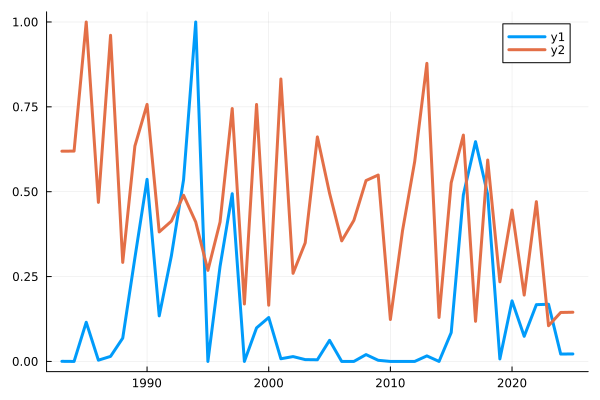

In [18]:
using Statistics
mu_t1 = dat1
mu_t1 = vcat([mean(mu_t1)],mu_t1,[mean(mu_t1)])
years = vcat([1500],dat.year, [2500])

mu_t2 = dat2
mu_t2 = vcat([mean(mu_t2)],mu_t2,[mean(mu_t2)])
years = vcat([1500],dat.year, [2500])

function mu(t,mu_t)
    ind_lower = maximum(eachindex(years)[years .<= t])
    ind_upper = minimum(eachindex(years)[years .> t])
    t_lower = years[ind_lower]
    t_upper = years[ind_upper]
    mu_lower = mu_t[ind_lower]
    mu_upper = mu_t[ind_upper]

    mu = mu_lower + (t-t_lower)/(t_upper-t_lower)*(mu_upper-mu_lower)
    return mu
end 
tvals = 1983:0.25:2025
Plots.plot(tvals, broadcast(t ->mu(t,mu_t1), tvals), linewidth = 3)
Plots.plot!(tvals, broadcast(t ->mu(t,mu_t2), tvals), linewidth = 3)

In [19]:
X = CSV.read("../processed_data/sst_500m_bins.csv",DataFrame)[:,:2:end]
unique(X.variable)
X = X[broadcast(v -> v in names(dat),X.variable),: ]
X[1:4,:]

Row,year,variable,value
,Float64,String15,Float64
1,1985.38,lat_36_00450,0.0751183
2,1985.38,lat_36_00900,0.0751183
3,1985.38,lat_36_01350,0.0751183
4,1985.38,lat_36_01800,0.0751183


In [20]:
include("../src/UDE2.jl")
model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1;hidden = 10,seed = 456)
nothing

In [21]:
function training!(model,reg_weight)
α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", regularization_weight = reg_weight, 
        optim_options = (maxiter = 750, step_size = 0.025), loss_options = (σ = 0.05, τ = 0.05, T = 160))
end
training!(model,1e2)
nothing

162
3.164594583e6 6.355751908e6 2.892434147e6 3.100319259e6 3.527743401e6 3.541732654e6 3.440240142e6 3.255318335e6 2.990849695e6 2.682502274e6 2.372121598e6 2.089909779e6 1.858918794e6 1.690815976e6 1.565167116e6 1.4510744e6 1.354352909e6 1.299673452e6 1.282726618e6 1.275270968e6 1.261233362e6 1.248405123e6 1.241194236e6 1.226825252e6 1.194380507e6 1.151315754e6 1.11134955e6 1.078248887e6 1.047777668e6 1.017282907e6 988624.492 964142.164 943789.722 926198.995 910734.126 897891.531 888183.9 881115.919 875258.689 869148.2 862133.395 854520.338 846994.389 839876.101 832857.655 825411.786 817414.145 809348.584 801881.219 795316.198 789553.085 784483.225 780217.81 776848.922 774132.271 771579.737 768870.368 766065.849 763399.117 760948.508 758588.687 756200.756 753819.279 751548.485 749410.188 747342.892 745331.123 743464.939 741841.097 740440.09 739139.667 737838.697 736530.654 735252.998 734006.713 732757.831 731498.199 730263.488 729086.349 727962.903 726879.303 725845.917 724880.668 72

In [ ]:
UniversalDiffEq.leave_future_out(model,x -> training!(x,1e5),10,path="../results/cv/model2_50_500m_1e5.csv")
UniversalDiffEq.leave_future_out(model,x -> training!(x,1e6),10,path="../results/cv/model2_50_500m_1e6.csv")
UniversalDiffEq.leave_future_out(model,x -> training!(x,1e7),10,path="../results/cv/model2_50_500m_1e7.csv")

162
5.440663808e6 8.460561513e6 4.967701303e6 5.110558765e6 5.450153297e6 5.378848185e6 5.194524771e6 4.941392827e6 4.622354191e6 4.260188071e6 3.893271389e6 3.551110206e6 3.254365052e6 3.009635333e6 2.800404616e6 2.607707408e6 2.440055023e6 2.319900654e6 2.246764245e6 2.193265763e6 2.140906565e6 2.09230937e6 2.046197841e6 1.987081875e6 1.909819246e6 1.827366424e6 1.750267593e6 1.676337876e6 1.603268947e6 1.535865725e6 1.47820071e6 1.428511994e6 1.383227697e6 1.341583239e6 1.304865679e6 1.273322454e6 1.245194507e6 1.218349808e6 1.192039262e6 1.166872953e6 1.143489821e6 1.121606739e6 1.100321841e6 1.079066875e6 1.058033423e6 1.037657563e6 1.017939639e6 998604.852 979923.298 962842.699 947912.581 934630.358 922536.129 911951.557 902744.764 893994.647 885544.697 877790.849 870227.882 862540.257 855333.361 848405.023 841501.354 835176.317 829188.627 823389.225 818189.76 813238.126 808540.567 804261.123 800023.316 796006.567 792177.55 788391.069 784878.108 781425.68 778136.574 775021.246 77

In [23]:
using JLD2
save_object("../results/parameters/model2_0.05_1e4.jld",model.parameters)

In [24]:
rhs = UniversalDiffEq.get_right_hand_side(model)
f_rhs = (u,X,site) -> rhs(zeros(length(K)) .+ u  , repeat([X],65), 2000.0)[site]
f_rhs(0.0,0.0,2)

-0.19735630713396318

In [25]:
Xvals = -2.5:0.75:2.5; site = 25
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), clor = colors[1],o label = "",width=3)
i = 0
for X in Xvals
    i += 1
    Plots.plot!(p1,exp.(uvals),exp.(uvals).*f_rhs.(uvals,X,site), color = colors[i], label = string("",round(X,digits = 3)),width=3)
end
Plots.plot!(p1, xlabel = "Kelp cover", ylabel = "Change in cover", legendtitle = "SST anom.",legendposition = :bottomleft)

Base.Meta.ParseError: ParseError:
# Error @ /Users/johnbuckner/github/KelpUDEs/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:4:90
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), clor = colors[1],o label = "",width=3)
#                                                                                        └────────────────┘ ── Expected `)`

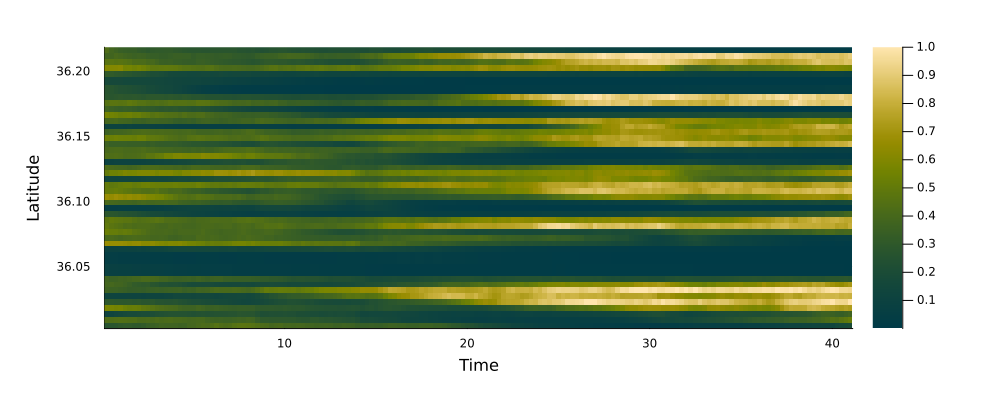

In [26]:
u = model.parameters.uhat[:,1]
X = [0.0,0.0] .+ -2.0
T = 2025-1984
dt = 0.25
uvals = zeros(length(K), round(Int,T/dt))
i = 0
for t in (1984+dt):dt:2025
    i+=1
    u[u.>0] .= 0
    uvals[:,i] = u
    X = model.process_model.covariates(t)
    u = u + dt*rhs(u,X,t).+sqrt(dt)*0.05*randn(length(K))
end

function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))

using Plots.PlotMeasures
Plots.heatmap(dt:dt:T,lats,exp.(uvals), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

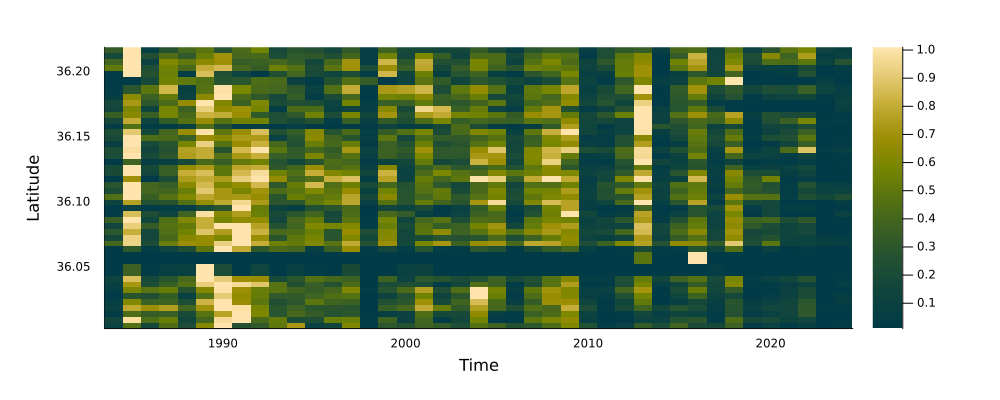

In [27]:
Plots.heatmap(dat.year,lats,exp.(Matrix(dat[:,2:end]))', c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

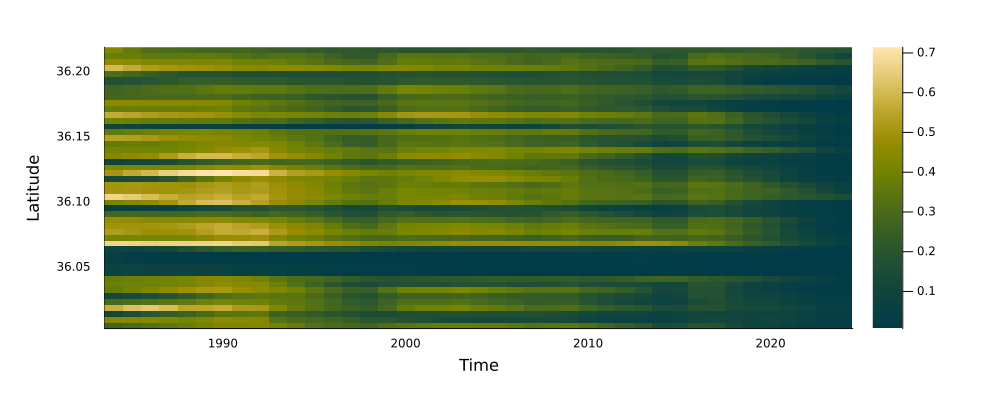

In [28]:
Plots.heatmap(dat.year,lats,exp.(Matrix(model.parameters.uhat)), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

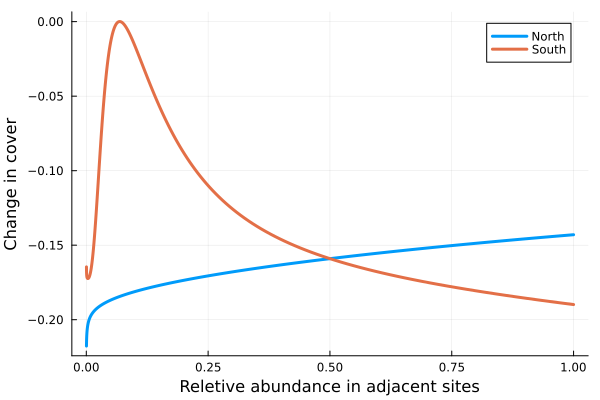

In [29]:
rhs = UniversalDiffEq.get_right_hand_side(model)
function f_rhs1_(u,X,site)
    u0 = K.+log(0.5)
    u0[site + 1] = u .+ K[site+1]
    rhs(u0, repeat([X],length(K)), 2000.0)[site]
end
function f_rhs2_(u,X,site)
    u0 = K.+log(0.5)
    u0[site - 1] = u .+ K[site-1]
    rhs(u0, repeat([X],length(K)), 2000.0)[site]
end

Xvals = -2.5:0.75:2.5; site = 10
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp(0.5*K[site]).*f_rhs1_.(uvals,0.0,site), label = "North",width=3)
Plots.plot!(exp.(uvals),exp(0.5*K[site]).*f_rhs2_.(uvals,0.0,site),  label = "South",width=3, xlabel = "Reletive abundance in adjacent sites",
ylabel = "Change in cover")

In [30]:
length(model.parameters)

1961

In [31]:
optim_opts = (samples = 4000, burnin = 2000, Σ0 = 2*1e-3)
params,nll,interp = UniversalDiffEq.train!(model; 
                        loss_function = "spline gradient matching", optimizer = "MCMC",
                        regularization_weight = 1e1, loss_options = (σ = 0.1, τ = 0.05, T = 60, α = α),
                        optim_options = optim_opts, verbose = false)
Plots.plot(nll)

UndefVarError: UndefVarError: `α` not defined

In [32]:
function get_samples(Nsteps)
    seeds = [123,234,345,456,567,678]; Nchains = length(seeds)
    model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1;hidden = 10,seed = seeds[1])
    training!(model,1e2)
    parameters = Vector{typeof(params)}(undef, Nsteps*Nchains)
    for i in 1:Nchains
        optim_opts = (samples = 20000, burnin = 5000, Σ0 = 2*1e-3)

params,nll,interp = UniversalDiffEq.train!(model_sgld; 
                        loss_function = "spline gradient matching", optimizer = "MCMC",
                        regularization_weight = 1e1, loss_options = (σ = 0.1, τ = 0.05, T = 60, α = α),
                        optim_options = optim_opts, verbose = false)
    end
end 

get_samples (generic function with 1 method)